## Summary notes

Use Holt's exponential smoothing method to model a non-seasonal time series with a trend.

Data was sourced from Rdatasets[^1] using StatsModels `Datasets` package.[^2]

We use StatsModels' `Holt`[^3] class to model the time series.

Fitting the time series using the `Holt.fit` method returns an instance of `HoltWinterResult`.[^5]

This topic is covered in M249, Book 2, Parts 2.7 & 2.9

## Dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st
from statsmodels import api as sm
from statsmodels import datasets
from statsmodels.tsa import api as tsa
from statsmodels.graphics import tsaplots
from matplotlib import pyplot as plt
import seaborn as sns

Set the graphing defaults.
(This is optional.)

In [2]:
sns.set_theme()

## Main

### Load the data

In [3]:
hartnagel = datasets.get_rdataset('Hartnagel', package='carData', cache=True)
hartnagel.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      38 non-null     int64  
 1   tfr       38 non-null     int64  
 2   partic    38 non-null     int64  
 3   degrees   38 non-null     float64
 4   fconvict  38 non-null     float64
 5   ftheft    34 non-null     float64
 6   mconvict  38 non-null     float64
 7   mtheft    34 non-null     float64
dtypes: float64(5), int64(3)
memory usage: 2.5 KB


### Initialise and plot the time series

The first observation is in 1931.

In [4]:
hartnagel.data['year'].head(1)

0    1931
Name: year, dtype: int64

Initialise the `Series`.

In [5]:
ts_fertility = pd.Series(
    data=hartnagel.data['tfr'].to_numpy(),
    name='total fertility rate',
    index=pd.date_range(
        start='1931',
        periods=hartnagel.data['tfr'].size,
        freq='A-DEC',
        name='year'
    )
)
ts_fertility.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 38 entries, 1931-12-31 to 1968-12-31
Freq: A-DEC
Series name: total fertility rate
Non-Null Count  Dtype
--------------  -----
38 non-null     int64
dtypes: int64(1)
memory usage: 608.0 bytes


Plot the time series.

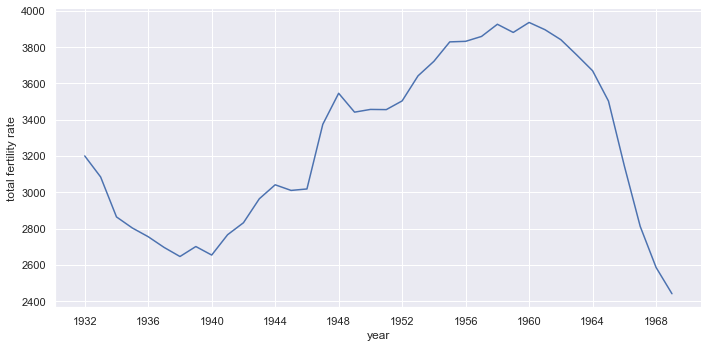

In [6]:
_g = sns.relplot(x=ts_fertility.index, y=ts_fertility, kind='line', aspect=2)
plt.show()

### Smooth the time series

Model and fit the time series.

In [7]:
holt = tsa.Holt(ts_fertility, initialization_method='estimated')
fitted = holt.fit()

Construct a `DataFrame` holding both the *observed* and *fitted* time series.

In [8]:
all_ts_fertility = pd.merge(
    left=ts_fertility.rename('obs'),
    right=fitted.fittedvalues.rename('fit'),
    left_index=True,
    right_index=True
)
all_ts_fertility.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 1931-12-31 to 1968-12-31
Freq: A-DEC
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   obs     38 non-null     int64  
 1   fit     38 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 912.0 bytes


Plot the observed and fitted time series.

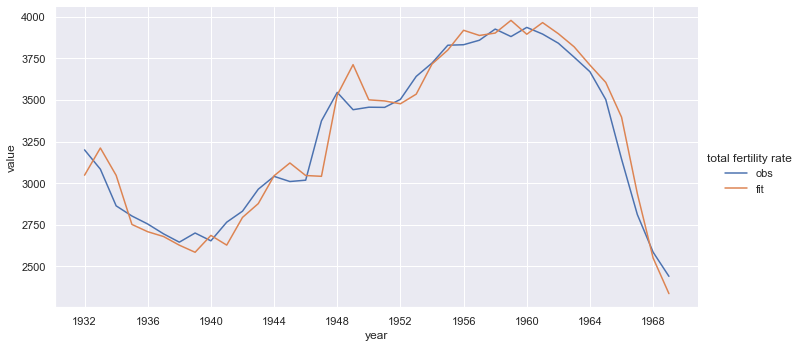

In [9]:
_gsource = all_ts_fertility.melt(
    var_name='total fertility rate',
    ignore_index=False
).reset_index()

g = sns.relplot(
            data=_gsource,
            x='year',
            y='value',
            hue='total fertility rate',
            kind='line',
            aspect=2
)
plt.show()

Get the fitted model's parameters.

In [10]:
pd.Series(
    data={
        'alpha': fitted.params['smoothing_level'],
        'gamma': fitted.params['smoothing_trend'],
        'sse': fitted.sse,
    },
    name='smoothing parameters'
)

alpha         0.985050
gamma         0.418600
sse      469164.239529
Name: smoothing parameters, dtype: float64

### Check the model

Plot the forecasting errors.

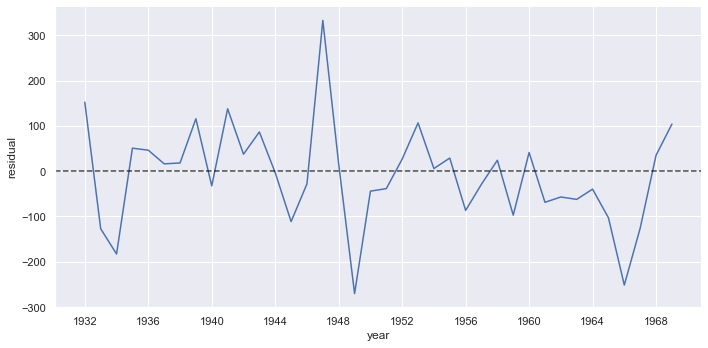

In [11]:
_g = sns.relplot(x=fitted.resid.index, y=fitted.resid, kind='line', aspect=2)
plt.axhline(0, alpha=0.7, ls='--', color='black')
plt.ylabel('residual')
plt.show()

Plot the in-sample autocorrelations.

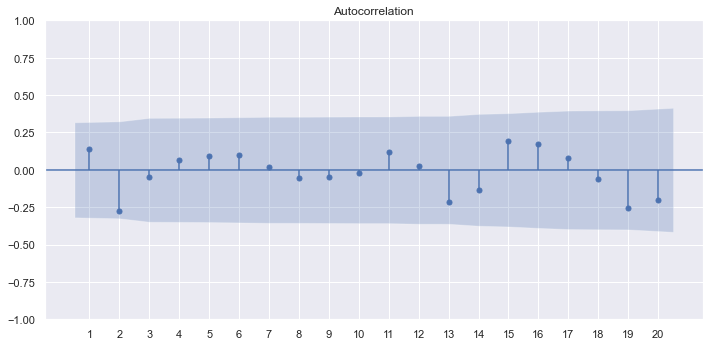

In [12]:
_f, _ax = plt.subplots(figsize=(11.8, 5.5))
tsaplots.plot_acf(fitted.resid, ax=_ax, lags=20, zero=False)
plt.xticks(range(1, 21))
plt.show()

Return the results of a Ljung-Box test.

In [13]:
sm.stats.acorr_ljungbox(fitted.resid, lags=[20])

,lb_stat,lb_pvalue
20,24.420038,0.224525


Plot a histogram of the forecasting errors.

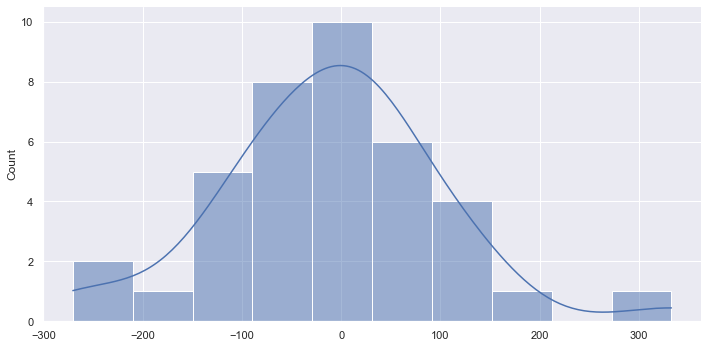

In [14]:
_g = sns.displot(
            x=fitted.resid,
            kind='hist',
            kde=True,
            aspect=2
)
plt.show()

### Forecasting

Plot forecasts for the next 3 years.

The merge is a *full outer join*[^4], given the indices of *all_ts_fertility* and *_fcast* do not overlap.

We initialise a variable to hold reference to the forecasted values, which we use later on to plot the vertial line separating the *observed*, *fitted* lines from the *forecast* line.

If you think the separator is unnecessary, then *_fcast* is not needed and the forecast could be moved directly into the `merge` function.

#### Plot of forecasts (+3 years)

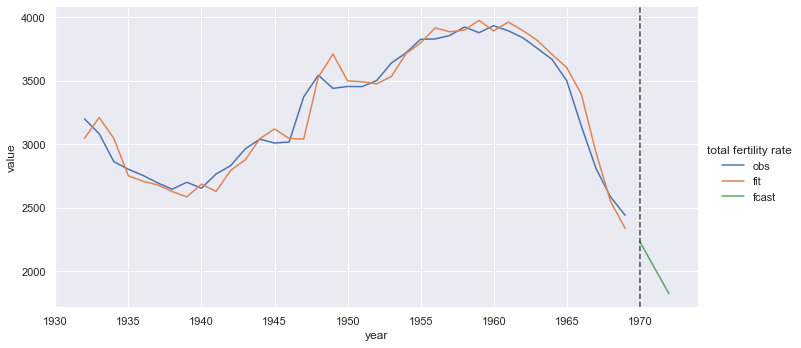

In [15]:
_fcast = fitted.forecast(3).rename('fcast')
_gsource = pd.merge(
    left=all_ts_fertility,
    right=_fcast,
    how='outer',
    left_index=True,
    right_index=True
).rename_axis(
    'year',
    axis=0
).melt(
    var_name='total fertility rate',
    ignore_index=False
).reset_index()

_g = sns.relplot(
            data=_gsource,
            x='year',
            y='value',
            hue='total fertility rate',
            kind='line',
            aspect=2
)
plt.axvline(_fcast.index[0], alpha=0.7, ls='--', color='black')
plt.show()

Quantify a forecast.

In [16]:
_fcast = fitted.forecast(1)[0]
_std_err = np.sqrt(
    st.norm().ppf(0.975) * (fitted.sse / fitted.fittedvalues.size)
)
pd.Series(
    data=[_fcast, _fcast - _std_err,_fcast + _std_err],
    index= ['pred', 'lpb', 'upb']
)

pred    2233.926398
lpb     2078.367557
upb     2389.485239
dtype: float64

[^1]: Arel-Bundock V (2022). Rdatasets: A collection of datasets originally distributed in various R packages. R package version 1.0.0, https://vincentarelbundock.github.io/Rdatasets
[^2]: See [The Datasets Package](https://www.statsmodels.org/devel/datasets/index.html)
[^3]: See [statsmodels.tsa.holtwinters.Holt](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.Holt.html)
[^4]: "*In theory, a **full outer join** is the combination of a left join and a right join. The full outer join includes all rows from the joined tables whether or not the other table has the matching row.*" ([sqltutorial.org](https://www.sqltutorial.org/sql-full-outer-join/))
[^5]: See [statsmodels.tsa.holtwinters.HoltWintersResults](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.HoltWintersResults.html)